In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import shutil
import time
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2022-11-01 03:42:11.583183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 03:42:11.583245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMG_PATH = '/home/jupyter/gurih_mas/digit_recognizer/dataset/'
LABEL_PATH = '/home/jupyter/gurih_mas/digit_recognizer/labels/'
MODEL_PATH = '/home/jupyter/gurih_mas/digit_recognizer/models/'
RESULT_PATH = '/home/jupyter/gurih_mas/digit_recognizer/results/'

In [3]:
df_221031 = pd.read_csv(os.path.join(LABEL_PATH,'221031_dataset/221031dataset.csv'), header=0, names=['ktp_pict','true_label'])
df_221031

,ktp_pict,true_label
001458fc-66d2-4753-bbcd-f13c256b87bf_10.jpg,train,0
001458fc-66d2-4753-bbcd-f13c256b87bf_4.jpg,train,0
0038fe12-2068-4af9-88bb-6233bcd9fcb4_14.jpg,train,0
004bb68a-9abd-40ea-9cb9-8cc9de9e4f6a_10.jpg,train,0
004bb68a-9abd-40ea-9cb9-8cc9de9e4f6a_12.jpg,train,0
...,...,...
e12060e9-1a8b-416a-a717-487c8fe403bd_9.jpg,test,9
ec81e81e-1672-40f6-9f1c-f3712ba2b7a7_5.jpg,test,9
ec8240b2-f8e8-46be-b3cd-9cdf944a26d0_3.jpg,test,9
ef8ef202-b0a9-4726-8cf2-bb0051fd6a22_10.jpg,test,9


In [4]:
df_221031.true_label.value_counts().sort_index() #Show data composition

0    630
1    630
2    630
3    630
4    630
5    630
6    630
7    630
8    630
9    621
Name: true_label, dtype: int64

### Loading dataset

In [5]:
TRAIN_PATH = '/home/jupyter/gurih_mas/digit_recognizer/dataset/221031_dataset/train'
TEST_PATH = '/home/jupyter/gurih_mas/digit_recognizer/dataset/221031_dataset/test'

batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int')

Found 4991 files belonging to 10 classes.


2022-11-01 03:44:03.522110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 03:44:03.522179: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 03:44:03.522214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (addin-gurihmas-dev): /proc/driver/nvidia/version does not exist
2022-11-01 03:44:03.540678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode =  'int')

Found 1300 files belonging to 10 classes.


In [7]:
# Extract train file
file_train_paths = train_ds.file_paths
file_train = pd.DataFrame(file_train_paths)
file_train.columns = ['filename']
print(file_train.shape)
file_train.head()

(4991, 1)


,filename
0,/home/jupyter/gurih_mas/digit_recognizer/datas...
1,/home/jupyter/gurih_mas/digit_recognizer/datas...
2,/home/jupyter/gurih_mas/digit_recognizer/datas...
3,/home/jupyter/gurih_mas/digit_recognizer/datas...
4,/home/jupyter/gurih_mas/digit_recognizer/datas...


In [8]:
filename_train = file_train.filename.str.rsplit("/", n=8, expand=True)
filename_train.columns = ['dir_1','dir_2','dir_3','dir_4','dir_5','dir_6','dir_7','dir_8','dir_9']

label_list = []
filename_train = filename_train[['dir_9','dir_8']]
for index,row in filename_train.iterrows():
    if row['dir_8'] == '0':
        label_list.append(0)
    elif row['dir_8'] == '1':
        label_list.append(1)
    elif row['dir_8'] == '2':
        label_list.append(2)
    elif row['dir_8'] == '3':
        label_list.append(3)
    elif row['dir_8'] == '4':
        label_list.append(4)
    elif row['dir_8'] == '5':
        label_list.append(5)
    elif row['dir_8'] == '6':
        label_list.append(6)
    elif row['dir_8'] == '7':
        label_list.append(7)
    elif row['dir_8'] == '8':
        label_list.append(8)
    elif row['dir_8'] == '9':
        label_list.append(9)

filename_train.columns=['filename','label']
filename_train['label'] = label_list
filename_train = filename_train.reset_index(drop=True)
print(filename_train.shape)
filename_train.head()

(4991, 2)


,filename,label
0,c6e23320-c5ae-476e-b983-b8b05c1ee7d9_0.jpg,6
1,6217b74d-3ca1-47b6-9a18-ceccfcf55e7b_6.jpg,5
2,0445281c-e97b-4f09-a9a1-4fcc7e10ae82_9.jpg,1
3,a7f84dfa-709e-44af-a840-1011420d9779_2.jpg,7
4,099f27ad-572e-4aa8-b80b-274911da2018_11.jpg,4


In [9]:
classes = train_ds.class_names
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


2022-11-01 03:44:39.174976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


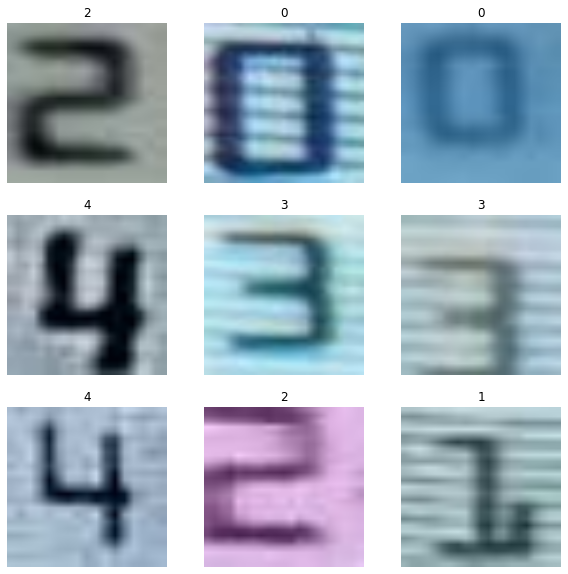

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.title(labels[i].numpy())
        plt.axis("off")

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of validation batches: 41


In [12]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))

Number of train batches: 156


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(len(classes),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810 

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


41/41 [==============================] - 14s 268ms/step - loss: 2.8689 - accuracy: 0.0754


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.87
initial accuracy: 0.08


In [29]:
ts = time.time()
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)
print("Finished in {} s".format(time.time() - ts))

Epoch 1/10
156/156 [==============================] - 58s 354ms/step - loss: 2.2167 - accuracy: 0.2230 - val_loss: 1.6345 - val_accuracy: 0.5023
Epoch 2/10
156/156 [==============================] - 60s 388ms/step - loss: 1.5048 - accuracy: 0.5089 - val_loss: 1.1954 - val_accuracy: 0.7023
Epoch 3/10
156/156 [==============================] - 56s 361ms/step - loss: 1.1545 - accuracy: 0.6588 - val_loss: 0.9601 - val_accuracy: 0.7669
Epoch 4/10
156/156 [==============================] - 56s 362ms/step - loss: 0.9630 - accuracy: 0.7191 - val_loss: 0.8216 - val_accuracy: 0.8023
Epoch 5/10
156/156 [==============================] - 55s 352ms/step - loss: 0.8242 - accuracy: 0.7764 - val_loss: 0.7280 - val_accuracy: 0.8254
Epoch 6/10
156/156 [==============================] - 56s 357ms/step - loss: 0.7386 - accuracy: 0.8012 - val_loss: 0.6610 - val_accuracy: 0.8485
Epoch 7/10
156/156 [==============================] - 56s 362ms/step - loss: 0.6758 - accuracy: 0.8127 - val_loss: 0.6091 - val_ac

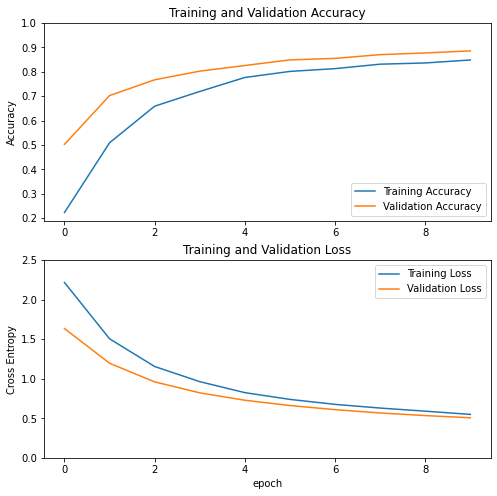

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [33]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
          metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810 

In [35]:
len(model.trainable_variables)

56

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

ts = time.time()
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
print("Finished in {} s".format(time.time() - ts))

Epoch 10/20
156/156 [==============================] - 92s 564ms/step - loss: 0.2646 - accuracy: 0.9199 - val_loss: 0.0609 - val_accuracy: 0.9823
Epoch 11/20
156/156 [==============================] - 92s 593ms/step - loss: 0.0603 - accuracy: 0.9812 - val_loss: 0.1215 - val_accuracy: 0.9638
Epoch 12/20
156/156 [==============================] - 88s 565ms/step - loss: 0.0362 - accuracy: 0.9870 - val_loss: 0.0422 - val_accuracy: 0.9908
Epoch 13/20
156/156 [==============================] - 92s 589ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.0286 - val_accuracy: 0.9892
Epoch 14/20
156/156 [==============================] - 89s 572ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.0304 - val_accuracy: 0.9931
Epoch 15/20
156/156 [==============================] - 93s 595ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0230 - val_accuracy: 0.9946
Epoch 16/20
156/156 [==============================] - 89s 573ms/step - loss: 5.6585e-04 - accuracy: 1.0000 - val_loss: 0.01

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

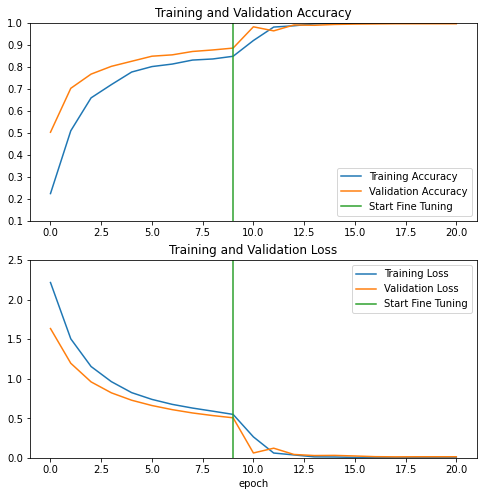

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

41/41 [==============================] - 14s 326ms/step - loss: 0.0132 - accuracy: 0.9962
Test accuracy : 0.9961538314819336


In [40]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(MODEL_PATH,'DR_MobileNetV2_v3.2.h5'))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
